<a href="https://colab.research.google.com/github/devdastl/-EVA-8_Phase-1_Assignment-4/blob/main/Bonus_step/EVA_assignment_4_BonusStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus code version setup in building the Neural Network
## **Target**
This is an extra step where we will try to achieve consistant upto 99.4% accruacy under 8k parameters

1. Since our model is already achieving desired targets in `9,930` parameters. We can utilize same Architecture and reduce parameters count by playing around number of channels.
2. we want to reduce parameters from `9,930` to something less then `8,000` to get the additional point as mentioned in the assignment.
3. Lets also add another augmentation known as ColorJitter which will play around with the brightness, contrast, etc. This will allow us to learn more rich features from image.


## **Result**
Below are the results of bonus code setup.
1. Total number of parameters - `7,926 (<8k)`
1. Training accuracy at 15th epoch - `99.26%`
1. Testing accuracy at 15th epoch - `99.46%`
1. Training accuracy at 20th epoch - `99.21%`
1. Testing accuracy at 20th epoch - `98.46%` 

## **Analysis**
Following are the analysis of this bonus code setup:
1. By reducing the number of channels in the fourth code setup CNN, we were able to hit parameter count of `7,926` which is lesser then `8,000`.
2. Reducing parameters count also reduces model complexity which lead to small underfitting as can be seen by test and train accuracy.

#### **We reached our objective of consistant >99.4% accuracy under 8k parameters and under 15 epochs**
- Test accuracy at 15th epoch - `99.49%`
- Consistant? - `YES` (consistantly hitting from 10th epoch onward till 20th)
- parameters - `7,926` (under 10k)

## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

- first transform perform rotation based image augmentation.
- second transform `transforms.ColorJitter` perfrom brightness, contrast based augmentation.
- third transform convert dataset into pytorch tensor.
- fourth transform will normalize the image by using mean and standerd deviation of complete dataset. We can use numpy to calculate this values as shown in cell 5.

output of cell 5 after commenting `transforms.Normalize` transformation in our `trian_transform` in below cell.
```
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - "mean: tensor(0.1307)"
 - "std: tensor(0.3081)"
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])
```
As shown above it gives values 0.1307 as mean and 0.3081 as standerd deviation.

In [34]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split
Here we are creating pytorch dataset set class for train and test set.

In [35]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## GPU and data loader setup
In below cell first we are checking if cuda devices(GPU) are available as well as we are setting up data loader for train and test set which will create batches of the set for training.

In [36]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model architecture
Here the CNN model just uses convolution, pooling and activation. One focus while building this architecture is to keep the parameters under 10k.
Model architecture is also shown in the github README.

**NOTE :** 
- We are setting no drop out in this architecture by setting `dropout_value=0`. Means no drop out will be performed while training and testing.
- Here we reduce 16 channel to 14 channel and 14 channel to 12 channel. Apart from it, complete architecute is same as mentioned in fourth code setup.

In [46]:
dropout_value = 0 # don't use drop out
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
      # First block of CNN--------------
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #out_channel reduced from 14 to 12
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #output_channel reduced from 16 to 14 
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), #in_channel reduced from 16 to 14 
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        # Second block of CNN---------------
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #output_channel reduced from 16 to 14 
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9

        # Third block of CNN---------------
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #in_channel and output_channel reduced from 16 to 14 
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        # Forth block of CNN---------------
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #in_channel and output_channel reduced from 16 to 14
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), #in_channel reduced from 16 to 14
        ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1x1x10 



    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool1(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x=self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model visualization
Here we are using external tool `torchsummary` to visualize our model architecture as well as the number of paramters (which are under 10k).

In [47]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 14, 22, 22]           1,512
      BatchNorm2d-10           [-1, 14, 22, 22]              28
             ReLU-11           [-1, 14, 22, 22]               0
          Dropout-12           [-1, 14, 22, 22]               0


# Training and Testing

In this cell we have writtern training and testing loop which will go through each batch of loader and will perfrom a forward pass and then gradient calcuation.

In [48]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Model training
Here we will loop through epoch and call our train and test functions which we have already defined.

**NOTE :** Here we are using step-wise learning rate decay `StepLR` from `torch.optim.lr_scheduler`

In [49]:
from torch.optim.lr_scheduler import StepLR #import lr decay module
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #setup optimizer, step_size, and decay rate(gamma) for lr decay.
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step() #step which will change lr in epochs. intervel to change is set by step_size

EPOCH: 0


Loss=0.14679266512393951 Batch_id=937 Accuracy=89.44: 100%|██████████| 938/938 [01:18<00:00, 11.96it/s]



Test set: Average loss: 0.0901, Accuracy: 9755/10000 (97.55%)

EPOCH: 1


Loss=0.11933142691850662 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [01:17<00:00, 12.09it/s]



Test set: Average loss: 0.0337, Accuracy: 9905/10000 (99.05%)

EPOCH: 2


Loss=0.25154855847358704 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [01:16<00:00, 12.23it/s]



Test set: Average loss: 0.0381, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.024080540984869003 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:16<00:00, 12.26it/s]



Test set: Average loss: 0.0310, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.1257375180721283 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:16<00:00, 12.29it/s]



Test set: Average loss: 0.0209, Accuracy: 9946/10000 (99.46%)

EPOCH: 5


Loss=0.047245509922504425 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [01:15<00:00, 12.44it/s]



Test set: Average loss: 0.0207, Accuracy: 9947/10000 (99.47%)

EPOCH: 6


Loss=0.02295660227537155 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [01:16<00:00, 12.25it/s]



Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH: 7


Loss=0.010020013898611069 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:15<00:00, 12.35it/s]



Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.042022764682769775 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:16<00:00, 12.32it/s]



Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)

EPOCH: 9


Loss=0.03649519011378288 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:17<00:00, 12.10it/s]



Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.014831786043941975 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:15<00:00, 12.35it/s]



Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Loss=0.043091852217912674 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:19<00:00, 11.80it/s]



Test set: Average loss: 0.0198, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.07796341925859451 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [01:17<00:00, 12.09it/s]



Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.016041133552789688 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:17<00:00, 12.11it/s]



Test set: Average loss: 0.0197, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.0026311047840863466 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [01:17<00:00, 12.06it/s]



Test set: Average loss: 0.0195, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.007067004218697548 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [01:16<00:00, 12.31it/s]



Test set: Average loss: 0.0201, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.02192021533846855 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:16<00:00, 12.21it/s]



Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.015229079872369766 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:15<00:00, 12.39it/s]



Test set: Average loss: 0.0200, Accuracy: 9946/10000 (99.46%)

EPOCH: 18


Loss=0.009491045959293842 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:16<00:00, 12.27it/s]



Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.019737819209694862 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:16<00:00, 12.21it/s]



Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)



## Result visualization
Here we will visualize or plot graphs for train and test loss and accuracy with respect to the number of iteration. (1 iteration = pass from 1 batch)

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
train_loss_list = np.array([num.item() for num in train_losses ])


Text(0.5, 1.0, 'Test Accuracy')

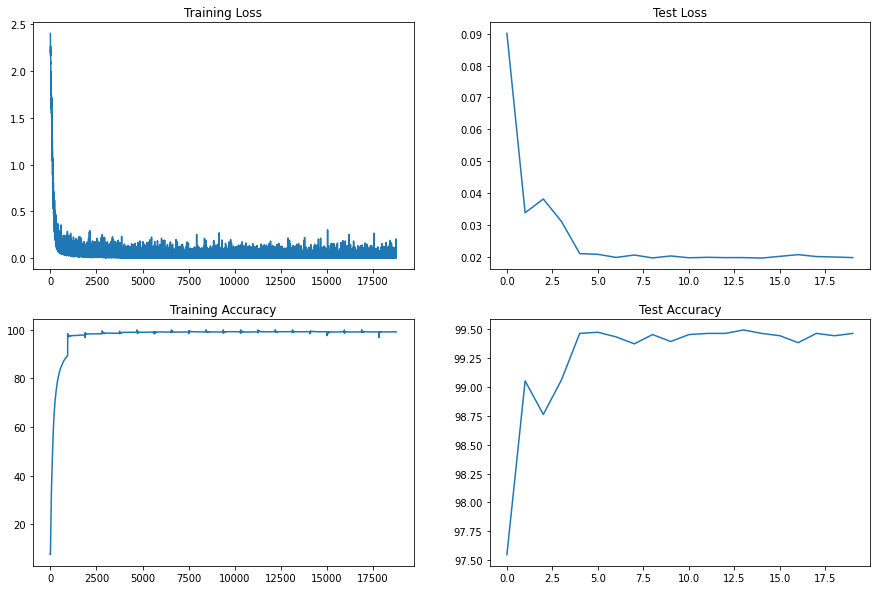

In [52]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_list)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")